<h1>LOAN PREDICTION PROBLEM</h1>

Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customer first apply for home loan after that company validates the customer eligibility for loan. Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers.

<b>PART I - IMPORTING LIBRARIES</b>

In [102]:
#Import Libraries
import pandas as pd 
import numpy as np #for mathematical calculations
import seaborn as sns  #for data visualization
import matplotlib.pyplot as plt #for plotting graphs
%matplotlib inline 
import warnings   #To ignore warnings
warnings.filterwarnings("ignore")

In [103]:
# The code was removed by Watson Studio for sharing.

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [104]:
#Load Test data set
body = client_1ab4ddc12160403791701f78e1cc1ff5.get_object(Bucket='loanprediction-donotdelete-pr-cnzzsirjewdxp8',Key='test_lAUu6dG.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
df_test = pd.read_csv(body)

<b>PART II - ANALISYS OF THE DATASET</b>

In [105]:
#Check how many Null values we do have in our train dataset
#I consider these methods to fill the missing values:
  #For categorical variables: Mode (Married,Gender, Dependent, Self_Employed, Credit_History,Loan_Amount_Term)
df_train['Gender'].fillna(df_train['Gender'].mode()[0], inplace=True) 
df_train['Dependents'].fillna(df_train['Dependents'].mode()[0], inplace=True) 
df_train['Self_Employed'].fillna(df_train['Self_Employed'].mode()[0], inplace=True) 
df_train['Credit_History'].fillna(df_train['Credit_History'].mode()[0], inplace=True) 
df_train['Loan_Amount_Term'].fillna(df_train['Loan_Amount_Term'].mode()[0], inplace=True) 
df_train['Married'].fillna(df_train['Married'].mode()[0], inplace=True) 
  #For numerical variables: Median (Loan_Amount)
df_train['LoanAmount'].fillna(df_train['LoanAmount'].median(), inplace=True)     

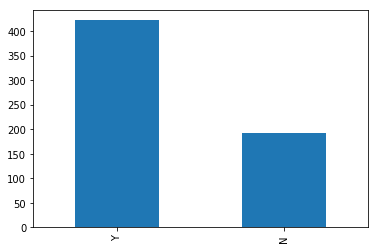

In [106]:
#Dataset Analysis. Train
df_train.dtypes
df_train.shape #(614,13)

#Dataset Analysis. Test
df_test.dtypes
df_test.shape #(367,12)

#Univariate Analysis. For categorical features I use frequency table or bar plots which will calculate the number of each category in a particular variable.
#For numerical features, I use probability density plots to look at the distribution of the variable.
#Target Value
df_train['Loan_Status'].value_counts(normalize=True)
#Plot Bar
df_train['Loan_Status'].value_counts().plot.bar() #Around 69% (422 out of 614) of the loans are granted

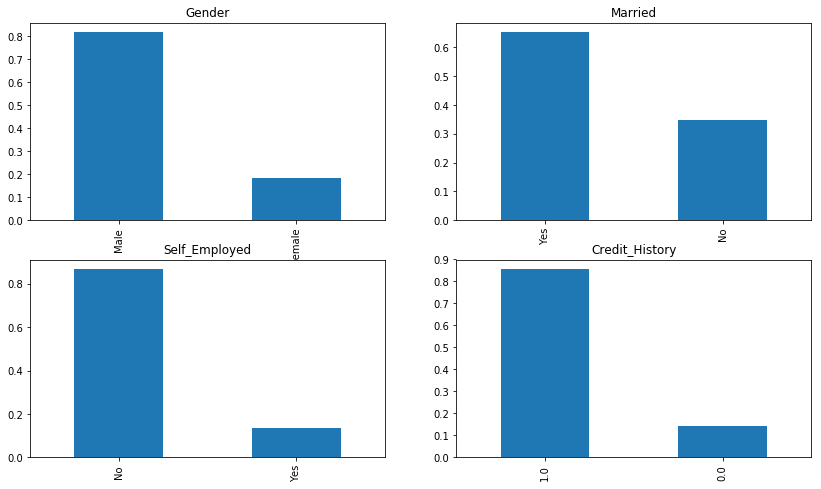

In [107]:
#Univariate Analysis of Categorical Independent Values: Gender, Married, Self_Employed
fig, axarr = plt.subplots(2, 2, figsize=(14, 8))
df_train['Gender'].value_counts(normalize=True).plot.bar(ax=axarr[0][0], title= 'Gender')
df_train['Married'].value_counts(normalize=True).plot.bar(ax=axarr[0][1], title= 'Married')
df_train['Self_Employed'].value_counts(normalize=True).plot.bar(ax=axarr[1][0], title= 'Self_Employed')
df_train['Credit_History'].value_counts(normalize=True).plot.bar(ax=axarr[1][1], title= 'Credit_History')

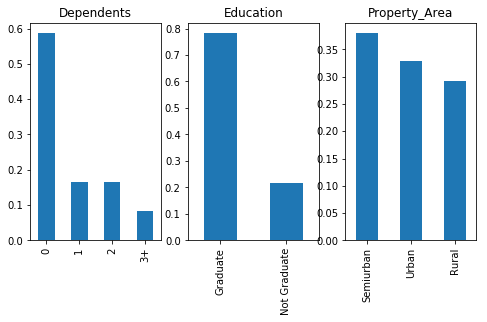

In [108]:
#Univariate Analysis of Ordinal Independent Values: Dependents, Education, Property_Area
fig, axarr = plt.subplots(1, 3, figsize=(8, 4))
df_train['Dependents'].value_counts(normalize=True).plot.bar(ax=axarr[0], title= 'Dependents')
df_train['Education'].value_counts(normalize=True).plot.bar(ax=axarr[1], title= 'Education')
df_train['Property_Area'].value_counts(normalize=True).plot.bar(ax=axarr[2], title= 'Property_Area')

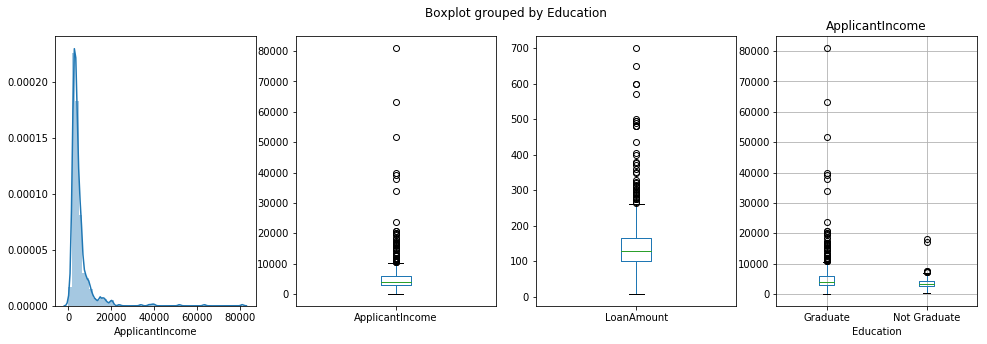

In [109]:
#Univariate Analysis of Numberical Independent Values: ApplicantIncome
fig, axarr = plt.subplots(1, 4, figsize=(8, 4))
sns.distplot(df_train['ApplicantIncome'],ax=axarr[0])
df_train['ApplicantIncome'].plot.box(figsize=(16,5),ax=axarr[1])
df_train['LoanAmount'].plot.box(figsize=(16,5),ax=axarr[2])
df_train.boxplot(column='ApplicantIncome', by = 'Education',ax=axarr[3])

Hypotheses testing using Bivariate Analysis:
<ul>
<li>Hypo 1 - Applicants with high income should have more chances of loan approval.</li>
<li>Hypo 2 - Applicants who have repaid their previous debts should have higher chances of loan approval.</li>
<li>Hypo 3 - Loan approval should also depend on the loan amount. If the loan amount is less, chances of loan approval should be high.</li>
<li>Hypo 4 - Lesser the amount to be paid monthly to repay the loan, higher the chances of loan approval.</li>
</ul>

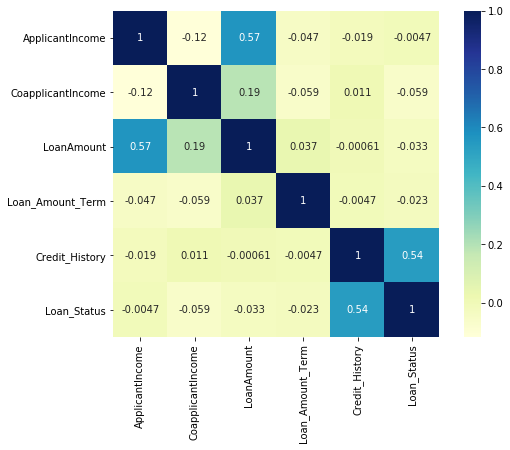

In [110]:
#Replace Loan_Amount (Y/N) values to (1/0)
df_train['Loan_Status'].replace('Y',1,inplace=True)
df_train['Loan_Status'].replace('N',0,inplace=True)
matrix = df_train.corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(matrix, square=True,annot=True, cmap="YlGnBu")

<li>The only place where there is a correlation is between Credit History and Loan Status (0.54 positive correlation), meaning that if the applicant has a good credit history he/she will have higher chances to get the Loan.</li>
<li>There is also a positive correlation between the Loan Amount and the Application Income.</li>

<b> PART III - MODEL BUILDING. A LOGISTIC REGRESSION</b>

In [111]:
#Remove Loan_ID value from both Data Sets as there is no need of this value for the computation
df_train = df_train.drop('Loan_ID', axis=1)
df_test_original = df_test['Loan_ID']
df_test = df_test.drop('Loan_ID', axis=1)

In [112]:
#Create y data set for the dependent varaiable as logistic regresion requires to have a dataset for the dependent var.
y=df_train['Loan_Status']
X=df_train.drop('Loan_Status',1)

In [113]:
#Turns categorical variables into a series of 0 and 1, making them lot easier to quantify and compare
X=pd.get_dummies(X) 
df_train=pd.get_dummies(df_train) 
df_test=pd.get_dummies(df_test)

In [114]:
#Split the model for training and testing
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size =0.3)
#Train the model
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
model = LogisticRegression() 
model.fit(x_train, y_train)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2', random_state=1, solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [115]:
#Predict the model and set the accuracy
pred_test = model.predict(x_test)
accuracy_score(y_test,pred_test)

0.8054054054054054

In [117]:
df_test['Credit_History'].fillna(df_test['Credit_History'].mode()[0], inplace=True) 
df_test['Loan_Amount_Term'].fillna(df_test['Loan_Amount_Term'].mode()[0], inplace=True) 

In [118]:
df_test.fillna(df_test.mean(), inplace=True)
pred_test_ds = model.predict(df_test)

In [119]:
body = client_1ab4ddc12160403791701f78e1cc1ff5.get_object(Bucket='loanprediction-donotdelete-pr-cnzzsirjewdxp8',Key='sample_submission_49d68Cx.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
df_ss = pd.read_csv(body)

In [120]:
df_ss['Loan_Status'] = pred_test_ds
df_ss['Loan_ID'] = df_test_original
df_ss['Loan_Status'].replace(1, 'Y', inplace=True) 
df_ss['Loan_Status'].replace(0, 'N', inplace=True) 

<b> PART IV - VALIDATION USING STRATIFIED K-FOLDS </b>